# Model Comparison & Selection

This notebook evaluates multiple forecasting models on the same
feature-engineered retail time-series dataset.

Objectives:
- Train multiple candidate models
- Compare performance using time-aware validation
- Select the best-performing model
- Persist the selected model for production use
- Generate model performance artifacts for dashboards


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import joblib
from pathlib import Path


In [2]:
DATA_PATH = Path("../data/processed/feature_engineered_data.csv")
df = pd.read_csv(DATA_PATH, parse_dates=["week"])

df.sort_values(["store_id", "product_id", "week"], inplace=True)
df.head()


,store_id,product_id,week,weekly_units_sold,weekly_units_ordered,avg_inventory_level,avg_price,avg_discount,holiday_promotion,lag_1_units_sold,lag_2_units_sold,lag_4_units_sold,rolling_4wk_avg,rolling_8wk_avg,rolling_4wk_std,week_over_week_change
0,S001,P0001,2022-02-14,994,847,230.857143,61.830000,7.857143,1,708.0,1032.0,1142.0,854.75,770.125,183.628928,0.403955
1,S001,P0001,2022-02-21,1222,875,275.428571,37.281429,12.857143,1,994.0,708.0,685.0,989.00,896.875,212.229436,0.229376
2,S001,P0001,2022-02-28,1259,644,348.714286,42.995714,9.285714,1,1222.0,994.0,1032.0,1045.75,966.000,253.832458,0.030278
3,S001,P0001,2022-03-07,983,990,326.142857,67.158571,11.428571,1,1259.0,1222.0,708.0,1114.50,1003.125,146.343204,-0.219222
4,S001,P0001,2022-03-14,946,704,197.857143,42.097143,14.285714,1,983.0,1259.0,994.0,1102.50,978.625,160.774169,-0.037640


In [8]:
TARGET = "weekly_units_sold"

FEATURES = [
    col for col in [
        "lag_1_units_sold",
        "lag_2_units_sold",
        "rolling_4wk_mean",
        "rolling_4wk_std",
        "price",
        "discount",
        "competitor_pricing",
        "seasonality"
    ]
    if col in df.columns
]

FEATURES


['lag_1_units_sold', 'lag_2_units_sold', 'rolling_4wk_std']

In [10]:
df = df.dropna(subset=FEATURES + [TARGET])


In [11]:
TARGET in df.columns


True

In [12]:
split_date = df["week"].quantile(0.8)

train_df = df[df["week"] <= split_date]
test_df  = df[df["week"] > split_date]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test  = test_df[FEATURES]
y_test  = test_df[TARGET]

len(train_df), len(test_df)


(8000, 1900)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

baseline_preds = X_test["lag_1_units_sold"]

baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_rmse = mean_squared_error(y_test, baseline_preds) ** 0.5

baseline_mae, baseline_rmse


(348.32105263157894, 438.8592317169116)

In [15]:
results = [{
    "model": "Naive_Lag1",
    "MAE": baseline_mae,
    "RMSE": baseline_rmse
}]


In [16]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

lin_preds = lin_model.predict(X_test)

lin_mae = mean_absolute_error(y_test, lin_preds)
lin_rmse = mean_squared_error(y_test, lin_preds) ** 0.5

results.append({
    "model": "Linear_Regression",
    "MAE": lin_mae,
    "RMSE": lin_rmse
})

lin_mae, lin_rmse


(260.9118609451141, 342.89588803624366)

In [19]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

ridge_preds = ridge_model.predict(X_test)

ridge_mae = mean_absolute_error(y_test, ridge_preds)
ridge_rmse = mean_squared_error(y_test, ridge_preds) ** 0.5

results.append({
    "model": "Ridge_Regression",
    "MAE": ridge_mae,
    "RMSE": ridge_rmse
})

ridge_mae, ridge_rmse


(260.911860908713, 342.89588795638076)

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds) ** 0.5

results.append({
    "model": "Random_Forest",
    "MAE": rf_mae,
    "RMSE": rf_rmse
})

rf_mae, rf_rmse


(252.8075087997071, 350.1460936802467)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr_model.fit(X_train, y_train)

gbr_preds = gbr_model.predict(X_test)

gbr_mae = mean_absolute_error(y_test, gbr_preds)
gbr_rmse = mean_squared_error(y_test, gbr_preds) ** 0.5

results.append({
    "model": "Gradient_Boosting",
    "MAE": gbr_mae,
    "RMSE": gbr_rmse
})

gbr_mae, gbr_rmse


(250.62926625129137, 340.8616024264394)

In [21]:
results_df = pd.DataFrame(results).sort_values("MAE")
results_df


,model,MAE,RMSE
4,Gradient_Boosting,250.629266,340.861602
2,Random_Forest,252.807509,350.146094
3,Ridge_Regression,260.911861,342.895888
1,Linear_Regression,260.911861,342.895888
0,Naive_Lag1,348.321053,438.859232


In [22]:
from sklearn.ensemble import GradientBoostingRegressor

final_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

final_model.fit(df[FEATURES], df[TARGET])


,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",200
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [23]:
import joblib
from pathlib import Path

MODEL_PATH = Path("../models/best_model.joblib")
joblib.dump(final_model, MODEL_PATH)

MODEL_PATH


WindowsPath('../models/best_model.joblib')

In [24]:
results_df.to_csv("../models/model_comparison_metrics.csv", index=False)


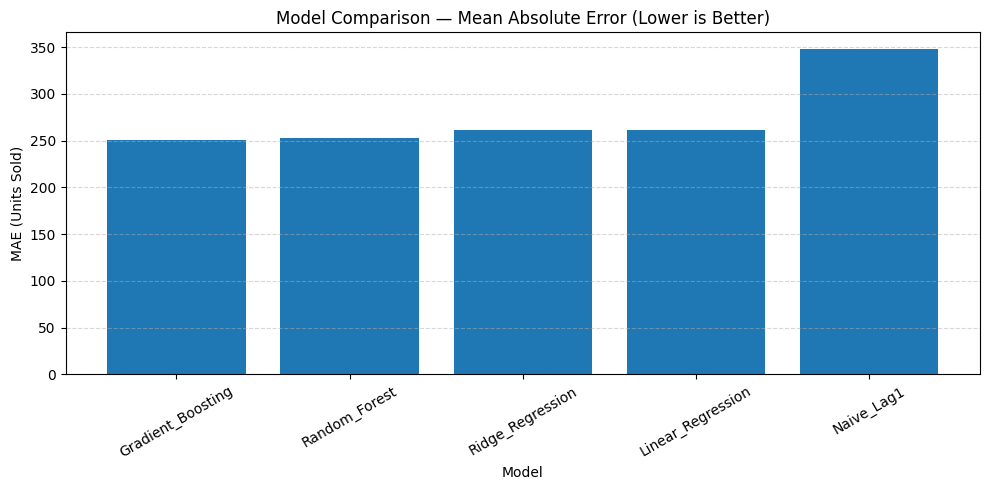

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.bar(
    results_df["model"],
    results_df["MAE"]
)

plt.title("Model Comparison — Mean Absolute Error (Lower is Better)")
plt.ylabel("MAE (Units Sold)")
plt.xlabel("Model")

plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


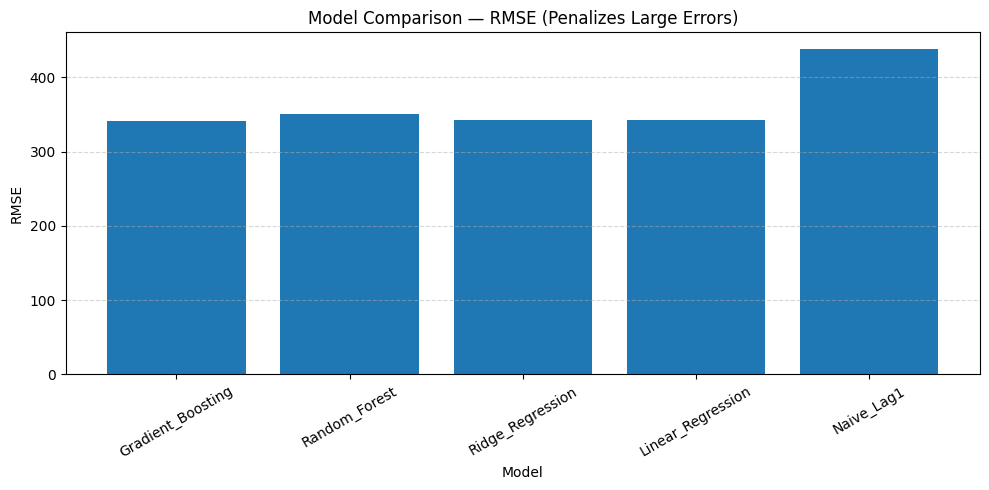

In [26]:
plt.figure(figsize=(10, 5))

plt.bar(
    results_df["model"],
    results_df["RMSE"]
)

plt.title("Model Comparison — RMSE (Penalizes Large Errors)")
plt.ylabel("RMSE")
plt.xlabel("Model")

plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


In [27]:
baseline_mae = results_df.loc[
    results_df["model"] == "Naive_Lag1", "MAE"
].values[0]

results_df["MAE_Improvement_%"] = (
    (baseline_mae - results_df["MAE"]) / baseline_mae
) * 100


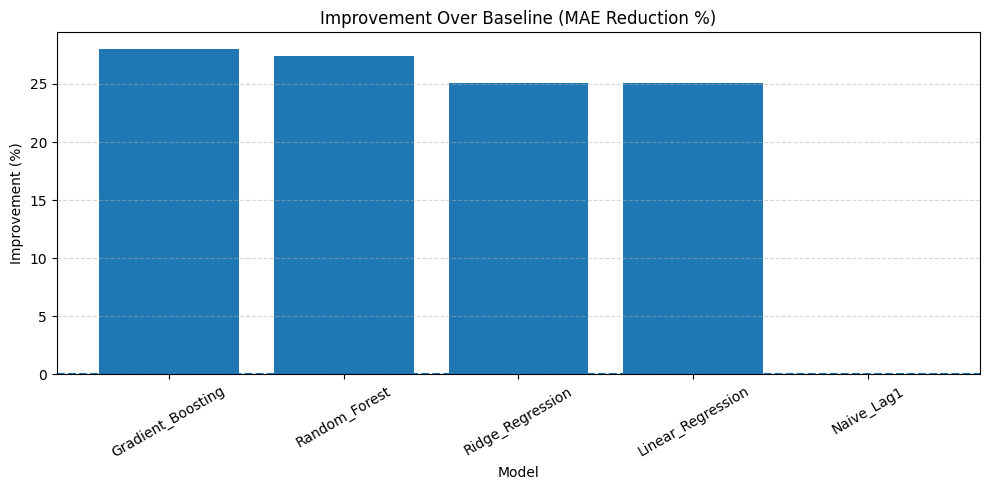

In [28]:
plt.figure(figsize=(10, 5))

plt.bar(
    results_df["model"],
    results_df["MAE_Improvement_%"]
)

plt.axhline(0, linestyle="--")
plt.title("Improvement Over Baseline (MAE Reduction %)")
plt.ylabel("Improvement (%)")
plt.xlabel("Model")

plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


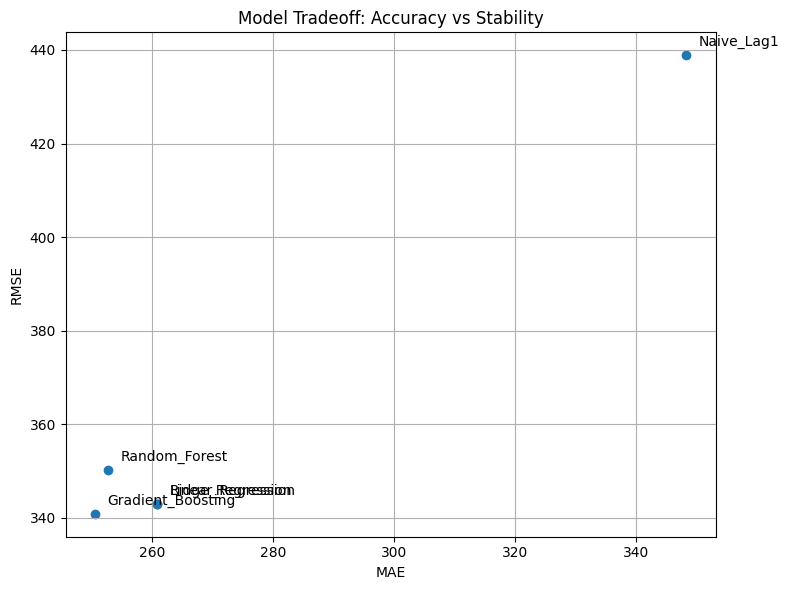

In [29]:
plt.figure(figsize=(8, 6))

plt.scatter(
    results_df["MAE"],
    results_df["RMSE"]
)

for i, model in enumerate(results_df["model"]):
    plt.text(
        results_df["MAE"].iloc[i] + 2,
        results_df["RMSE"].iloc[i] + 2,
        model
    )

plt.xlabel("MAE")
plt.ylabel("RMSE")
plt.title("Model Tradeoff: Accuracy vs Stability")
plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
best_model_row = results_df.sort_values("MAE").iloc[0]
best_model_name = best_model_row["model"]

best_model_name


'Gradient_Boosting'

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

final_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

final_model.fit(df[FEATURES], df[TARGET])


,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",200
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [32]:
import joblib
from pathlib import Path

MODEL_PATH = Path("../models/best_model.joblib")
joblib.dump(final_model, MODEL_PATH)

MODEL_PATH


WindowsPath('../models/best_model.joblib')

In [33]:
model_metadata = {
    "selected_model": best_model_name,
    "selection_metric": "MAE",
    "mae": float(best_model_row["MAE"]),
    "rmse": float(best_model_row["RMSE"]),
    "train_size": len(df),
    "features_used": FEATURES
}

pd.DataFrame([model_metadata]).to_csv(
    "../models/production_model_metadata.csv",
    index=False
)


# Final Outcome & Production Handoff

This notebook completes the model evaluation and selection phase for the
Retail Inventory Demand Predictor.

## Summary of Work
- Evaluated multiple forecasting models:
  - Naive baseline (Lag-1)
  - Linear Regression
  - Ridge Regression
  - Random Forest
  - Gradient Boosting
- Used time-aware train/test split to prevent data leakage
- Compared models using MAE (primary) and RMSE (secondary)
- Visualized performance and improvement over baseline
- Selected Gradient Boosting as the production model based on lowest MAE

## Production Decisions
- Model selection is performed offline for reproducibility
- The selected model is retrained on the full dataset
- Model artifact is saved as:
  - `models/best_model.joblib`
- Model metadata is saved as:
  - `models/production_model_metadata.csv`
- Backend services load the model and metadata without performing training or selection

## System Design Principle
Model governance and decision-making live in notebooks.
Inference and execution live in the backend.

This separation ensures:
- Stability in production
- Transparency for stakeholders
- Ease of future model upgrades

This notebook serves as the single source of truth for
forecasting model selection in the system.
